# Project Inscriptions -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io), February 2025**


In [1]:
import os
import polars as pl

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(code_dir)

In [3]:
from plot_utils import get_plotly_layout
from plot_utils import colors
width, height = 800, 450

In [4]:
# Existing dataset dir
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "plots"))

# Existing plots dir
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

## Exploratory Data Analysis


In [5]:
# Define the chain variables
chains = [
    'Arbitrum',
    'Base',
    'Ethereum',
    # 'BSC',
    # 'Fantom',
    'Optimism',
    'ZKsync Era'
]

plot_settings = {
    'Arbitrum': {'color': colors['blue'], 'label': 'Arbitrum', 'style': 'solid', 'width': 4, 'marker_symbol': 'circle'},
    'Base': {'color': colors['red'], 'label': 'Base', 'style': 'dash', 'width': 3.5, 'marker_symbol': 'diamond'},
    'Ethereum': {'color': colors['green'], 'label': 'Ethereum', 'style': 'dot', 'width': 3, 'marker_symbol': 'square'},
    'Optimism': {'color': colors['grey'], 'label': 'Optimism', 'style': 'dashdot', 'width': 2.5, 'marker_symbol': 'triangle-up'},
    'ZKsync Era': {'color': colors['pink'], 'label': 'zkSync', 'style': 'solid', 'width': 2, 'marker_symbol': 'cross'},
    'Fantom': {'color': colors['brown'], 'label': 'Fantom', 'style': 'dash', 'width': 1.5, 'marker_symbol': 'star'},
}

In [6]:
from datetime import datetime

start_date = datetime(2023, 11, 1)
end_date = datetime(2024, 2, 1)


def process_inscriptions(chain):
    file_fir = os.path.join(data_dir, "chains", chain+"_inscriptions.parquet")
    inscriptions_df = pl.scan_parquet(file_fir).collect(new_streaming=True)

    inscriptions_parsed = (inscriptions_df
                           .filter(pl.col('decoded_input_data').str.starts_with('data:,{'))
                           .with_columns(pl.col('decoded_input_data').str.slice(6).alias('decoded_input_data'))
                           .with_columns([
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.p").alias('p'),
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.op").alias('op'),
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.tick").alias('tick'),
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.amt").alias('amt'),
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.tx").alias('tx'),
                               pl.col('decoded_input_data').str.json_path_match(
                                   r"$.price").alias('price'),

                           ])
                           .select(
                               ['p', 'op', 'tick', 'amt']).drop_nulls())

    return inscriptions_parsed

In [7]:
# Initialize an empty dictionary to store the results
inscriptions_groups_dict = {}

# Loop over each chain, process the inscriptions, and store the result in the dictionary
for chain in chains:
    if chain == 'ZKsync Era':
        chain = 'ZKsync'
    inscriptions_group_dict = process_inscriptions(chain.lower())
    inscriptions_groups_dict[chain] = inscriptions_group_dict

In [8]:
def func_counts(data, column, top=4):
    value_counts = data[column].value_counts(sort=True)
    top_elements = value_counts.head(top)[column]
    value_counts = value_counts.with_columns(pl.when(pl.col(column).is_in(
        top_elements)).then(column).otherwise(pl.lit('Others')).alias(column))
    value_counts = value_counts.group_by(
        column).agg(pl.sum('count').alias('count'))
    value_counts = value_counts.with_columns((pl.col('count').truediv(
        value_counts['count'].sum()) * 100).alias('proportion'))
    return value_counts.sort('count', descending=True)


def get_top_protocols(data):
    value_counts = func_counts(data, 'p')
    return value_counts


def get_top_operations(data):
    value_counts = func_counts(data, 'op')
    return value_counts


def get_top_names(data):
    data = data.with_columns(
        (pl.col('p') + " " + pl.col('tick')).alias('name'))
    value_counts = func_counts(data, 'name')
    return value_counts

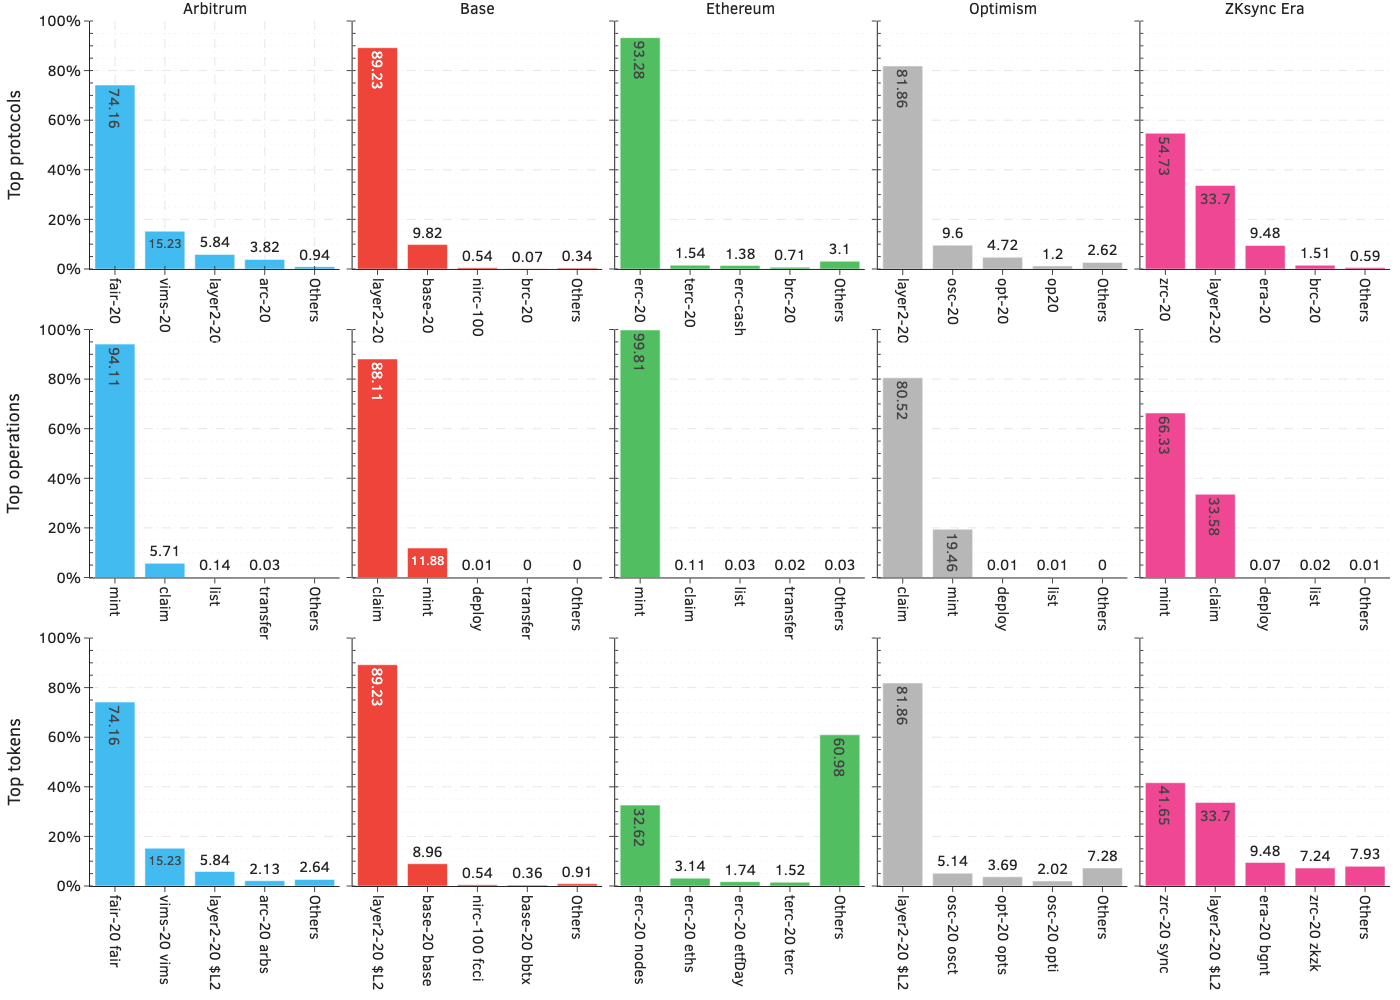

In [9]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def to_pandas(df):
    # Convert to Pandas DataFrame if needed
    if isinstance(df, pd.DataFrame):
        return df
    return df.to_pandas()


def move_others_to_end(df, column_name):
    # Utility function to move "Others" to the end of the DataFrame
    df = to_pandas(df)
    others_row = df[df[column_name] == 'Others']
    other_rows = df[df[column_name] != 'Others']
    return pd.concat([other_rows, others_row])


# Define the number of rows and columns for subplots
num_chains = len(chains)
fig = make_subplots(rows=3, cols=num_chains, subplot_titles=chains,
                    shared_xaxes=False, shared_yaxes=True, vertical_spacing=0.07, horizontal_spacing=0.01)

# for annotation in fig['layout']['annotations']:
#     annotation['font'] = dict(size=20)

# Loop over each chain to create the plots
for i, chain in enumerate(chains):
    # Fetch data for the current chain
    data = inscriptions_groups_dict[chain if chain !=
                                    'ZKsync Era' else 'ZKsync']

    # Plot the top protocols
    value_counts = get_top_protocols(data)
    value_counts = move_others_to_end(value_counts, 'p')
    fig.add_trace(go.Bar(
        x=value_counts['p'],
        y=value_counts['proportion'],
        marker_color=plot_settings[chain]['color'],
        text=value_counts['proportion'].round(2),
        textposition='auto',
        name=f'Top Protocols - {chain}',
    ), row=1, col=i+1)

    # Plot the top operations
    value_counts = get_top_operations(data)
    value_counts = move_others_to_end(value_counts, 'op')
    fig.add_trace(go.Bar(
        x=value_counts['op'],
        y=value_counts['proportion'],
        marker_color=plot_settings[chain]['color'],
        text=value_counts['proportion'].round(2),
        textposition='auto',
        name=f'Top Operations - {chain}'
    ), row=2, col=i+1)

    # Plot the top names
    value_counts = get_top_names(data)
    value_counts = move_others_to_end(value_counts, 'name')
    fig.add_trace(go.Bar(
        x=value_counts['name'],
        y=value_counts['proportion'],
        marker_color=plot_settings[chain]['color'],
        text=value_counts['proportion'].round(2),
        textposition='auto',
        name=f'Top Tokens - {chain}'
    ), row=3, col=i+1)

# Update layout for better appearance
fig.update_layout(get_plotly_layout(width=1400, height=1000),
                  barmode='group', showlegend=False, font=dict(size=15),
                  )

# Update x-axes and y-axes settings for all subplots
for row in range(1, 4):
    for col in range(1, num_chains + 1):
        fig.update_yaxes(minor_ticks="inside", showgrid=True, griddash='dash',
                         minor_griddash="dot", row=row, col=col, ticksuffix="%")
        fig.update_xaxes(tickangle=90, row=row, col=col)

fig.update_yaxes(range=[0, 100])

# Add y-axis labels for each row
fig.update_yaxes(title_text="Top protocols", row=1, col=1)
fig.update_yaxes(title_text="Top operations", row=2, col=1)
fig.update_yaxes(title_text="Top tokens", row=3, col=1)

# Save the figure
file_dir = os.path.realpath(os.path.join(plots_dir, "all.pdf"))
fig.write_image(file_dir, scale=1)

# Show the figure
fig.show("png")